In [64]:
import psycopg2
import pandas as pd
import sys

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
from scipy.stats import kde

sns.set_style("whitegrid", {'axes.grid' : False})

### Functions to query the databases

In [65]:
# create connection
def get_db_handle(dbname="testdb", rolename ="spotify"):
    com = None
    constr = "host='localhost' dbname='"+dbname+"'  user='"+rolename+"' password='ics'"
    try:
        con = psycopg2.connect(constr)
    except Exception as e:
        if con: 
            con.rollback()
        print('Error creating or connecting handle', str(e))
        sys.exit(1)
    if con is None:
        print('Error creating handle', str(e))
        sys.exit(1)
    return con

In [66]:
# open a cursor and fetch db to a pandas dataframe
def query_db_translate_to_pandas(con, querystring):
    df = None
    try:
        cur = con.cursor()
        df = pd.read_sql(querystring, con)
    except Exception as e:
        con.rollback() # meaning break the connection safely
        print("Error in printing table", str(e))
    return df

In [67]:
def close_db(handle1):
    if handle1:
        handle1.close()
    return

### Get data from Alltracks 

In [68]:
con = get_db_handle()
print(con)
querystr = "select * from alltracks"
#  querystr = "select id, name, from alltracks"
#where name like \'%Shri%\'"
df = query_db_translate_to_pandas(con, querystr)
#   print(df.shape)
#   print(df.to_string())

<connection object at 0x1a0fffe190; dsn: 'user=spotify password=xxx dbname=testdb host=localhost', closed: 0>


### Get data from Featuredb

In [9]:
con = get_db_handle()
#     print(con)
querystr = "select * from featuredb"
    #where name like \'%Shri%\'"
df = query_db_translate_to_pandas(con, querystr)
#     print(df.to_string())
print(df.columns)
print(df.sp_key)
# print(df.shape)

Index(['id', 'name', 'url', 'sp_danceability', 'sp_energy', 'sp_key',
       'sp_loudness', 'sp_mode', 'sp_speechiness', 'sp_acousticness',
       'sp_instrumentalness', 'sp_liveness', 'sp_valence', 'sp_tempo',
       'gn_gnid', 'gn_genre_1', 'gn_genre_2', 'gn_genre_3', 'gn_mood_1',
       'gn_mood_2', 'gn_tempo_1', 'gn_tempo_2', 'gn_tempo_3'],
      dtype='object')
0       11
1        7
2        1
3        6
4        0
5        6
6        7
7        9
8        8
9        7
10       0
11       5
12       7
13       0
14       1
15       9
16      11
17       6
18       6
19       6
20       6
21       7
22       0
23       7
24       2
25       7
26       1
27       1
28       1
29       6
        ..
8991    11
8992    10
8993     1
8994     7
8995     3
8996     7
8997     7
8998     3
8999     7
9000     9
9001     2
9002     8
9003     1
9004     6
9005     7
9006     7
9007     8
9008     2
9009     6
9010     8
9011     7
9012     5
9013     6
9014     1
9015     1
9016     6
9017

In [42]:
# Affinity propagation on IND dataset

from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from sklearn.preprocessing import scale
import numpy as np

df_allData = df
X = df_allData[["sp_valence", "sp_energy", "sp_danceability", "sp_speechiness", "sp_acousticness", "sp_instrumentalness", "sp_tempo", "sp_key"]].astype('float64') #'sp_danceability', 'sp_energy', 'sp_key',
X= X.as_matrix(columns=None) #imports X as numpy matrix



In [43]:
# normalizing
X_normed = X / X.max(axis=0)
X= X_normed
print(X)

[[  9.73305955e-02   1.11222445e-01   1.56587473e-01 ...,   4.40643863e-06
    3.02174184e-01   1.00000000e+00]
 [  2.91581109e-01   4.74949900e-01   5.10799136e-01 ...,   8.87323944e-01
    4.50250970e-01   6.36363636e-01]
 [  4.12731006e-02   1.02204409e-02   2.58099352e-01 ...,   2.97786720e-02
    3.39085472e-01   9.09090909e-02]
 ..., 
 [  3.60369610e-01   5.91182365e-01   6.02591793e-01 ...,   9.14486922e-01
    6.10222135e-01   6.36363636e-01]
 [  7.47433265e-02   1.42284569e-01   2.96976242e-01 ...,   7.47484909e-01
    6.29627817e-01   1.81818182e-01]
 [  3.91170431e-01   2.18436874e-02   2.79697624e-01 ...,   4.48692153e-01
    3.74328077e-01   4.54545455e-01]]


In [58]:

# data = scale(X.data)
# X = StandardScaler().fit_transform(X) #normalize dataset
# dissimilarity= np.amax(euclidean_distances(X, X))
# print(dissimilarity)

af = AffinityPropagation(damping = 0.7, max_iter=200, convergence_iter=15, preference=-15).fit(X)
#af = AffinityPropagation(damping = 0.7, max_iter=200, convergence_iter=15).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))


# # #############################################################################
# # Plot result
# import matplotlib.pyplot as plt
# from itertools import cycle

# plt.close('all')
# plt.figure(1)
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X[cluster_centers_indices[k]]
#     plt.plot(X[class_members, 0], X[class_members, 1], col + '.', alpha =0.3)
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14, alpha =0.3)
#     for x in X[class_members]:
#         plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, alpha =0.5)
        

# plt.xlabel('valence')
# plt.ylabel('energy')
# plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/IndianClassicalMusic/Week2/affinity_propagation.jpg', dpi = 300)
# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

Estimated number of clusters: 24
Silhouette Coefficient: 0.212


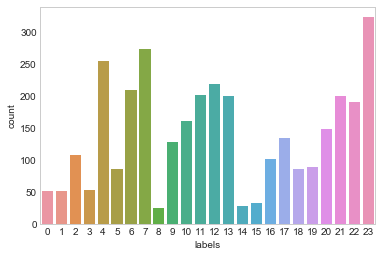

In [59]:
# print(str(labels))
df_allData[['labels']] = pd.DataFrame(labels)
# print(df_allData.columns)

# compute distribution
# get indices of all points classified as peaceful
peaceful_labels = df_allData[df_allData['gn_mood_1']== "Peaceful"]['labels']
sns.countplot(peaceful_labels)

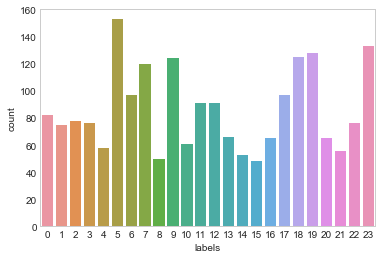

In [60]:
# get indices of all points classified as somber
serious_labels = df_allData[df_allData['gn_mood_1']== "Serious"]['labels']
sns.countplot(serious_labels)

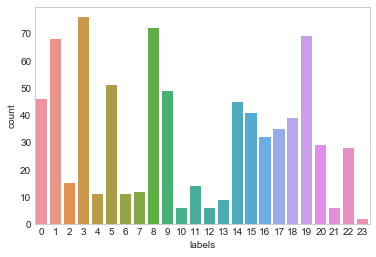

In [61]:
# get indices of all points classified as somber
fiery_labels = df_allData[df_allData['gn_mood_1']== "Fiery"]['labels']
sns.countplot(fiery_labels)

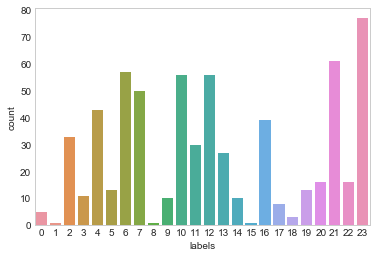

In [62]:
# get indices of all points classified as somber
somber_labels = df_allData[df_allData['gn_mood_1']== "Somber"]['labels']
sns.countplot(somber_labels)

### Distribution of songs across primary GN mood labels

In [69]:
# Peaceful is most prominent mood
df_dist = df[['id', 'gn_mood_1']].groupby(['gn_mood_1']).aggregate('count').sort_values('id').reset_index()
df_dist = df_dist.sort_values('id', ascending= False)
sns.barplot(x = 'id', y = 'gn_mood_1', data = df_dist)
percentage = []
for x in df_dist['id'].as_matrix():
    percentage.append(x*100/(np.sum(df_dist['id'].as_matrix())))
print(percentage)
plt.xticks(rotation=90);
plt.xlabel('count')
plt.ylabel('mood label from Gracenote')
plt.xlabel('count')
plt.tight_layout()
plt.savefig('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/IndianClassicalMusic/Week3/GNsongDistr.jpg', dpi = 300)

KeyError: "['gn_mood_1'] not in index"

In [70]:
# get mood labels from gracenote
mood_1 = df.gn_mood_1.unique().tolist()
print(mood_1)
mood_2 = df.gn_mood_2.unique().tolist()
print(mood_2)
print(len(mood_1), len(mood_2))

AttributeError: 'DataFrame' object has no attribute 'gn_mood_1'

## Plot a heat-map of gracenote mood_1 vs mood_2

In [71]:
### make a new df that has rows as mood_1 and colums as mood_2 and value as the number of times the combination appeared
# get count of each of 2500 emotions
df_m1m2 = df
df_m1m2 = df_m1m2[['id','gn_mood_1', 'gn_mood_2']].groupby(['gn_mood_1', 'gn_mood_2']).agg(['count']).reset_index()

#print(df_m1m2.to_string())
#print(df_m1m2['id'])
#print(type(df_m1m2['id']))
#print(df_m1m2['id']['count'])
frames = [df_m1m2['gn_mood_1'], df_m1m2['gn_mood_2'], df_m1m2['id']['count']]
result = pd.concat(frames, axis=1)

# df_nw = pd.DataFrame()
# df_nw.loc['gn_mood_1'] = df_m1m2.loc['gn_mood_1']

df_hm = result.pivot("gn_mood_2", "gn_mood_1", "count")
ax = sns.heatmap(df_hm)
ax = sns.heatmap(df_hm)

print(result['count'].astype(bool).sum(axis=0))

KeyError: "['gn_mood_1' 'gn_mood_2'] not in index"

## Digging into peaceful

In [168]:
# create a dataframe to store all mean valence energy values
df_mean_values = pd.DataFrame()
df_mean_values['mood_1'] = mood_1
df_mean_values['mean_valence'] = 0
df_mean_values['mean_energy'] = 0
df_mean_values.to_string

<bound method DataFrame.to_string of            mood_1  mean_valence  mean_energy
0        Peaceful             0            0
1   Sophisticated             0            0
2         Serious             0            0
3          Somber             0            0
4           Fiery             0            0
5       Easygoing             0            0
6        Stirring             0            0
7      Melancholy             0            0
8         Sensual             0            0
9          Lively             0            0
10       Brooding             0            0
11         Gritty             0            0
12       Romantic             0            0
13         Urgent             0            0
14    Sentimental             0            0
15        Defiant             0            0
16     Empowering             0            0
17         Upbeat             0            0
18     Energizing             0            0
19       Yearning             0            0
20           Cool 

In [158]:
# # create a dataframe with songs that are not classified as peaceful by GN
# df_notpeaceful = df[df['gn_mood_1']!='Peaceful']

# create a dataframe with songs that are classified as peaceful by GN
df_peaceful = df[df['gn_mood_1']=='Peaceful']

In [159]:
# df_notpeaceful.dtypes;
df_peaceful.dtypes;

In [160]:
# convert values to float
# df_notpeaceful_sp = df_notpeaceful
df_peaceful_sp    = df_peaceful
# df_notpeaceful_sp = df_notpeaceful_sp[['sp_valence', 'sp_energy']].astype('float64')
df_peaceful_sp    = df_peaceful_sp[['sp_valence', 'sp_energy']].astype('float64')

In [63]:
# sns.jointplot(x='sp_valence', y='sp_energy', data=df_notpeaceful_sp, kind ='reg')
# ax = plt.gca()
# ax.set_title("Not Peaceful")
sns.jointplot(x='sp_valence', y='sp_energy', data=df_peaceful_sp, kind ='kde')
print("Valence mean: ", df_peaceful_sp['sp_valence'].mean())
df_mean_values.loc['Peaceful','mean_valence'] = df_peaceful_sp['sp_valence'].mean()
df_mean_values.loc['Peaceful','mean_energy'] = df_peaceful_sp['sp_energy'].mean()
print("Energy mean: ", df_peaceful_sp['sp_energy'].mean())
ax = plt.gca()
plt.ylabel('Energy')
plt.xlabel('Valence')
# ax.set_title("Peaceful")
# (0.95, 0.5) = desired

NameError: name 'df_peaceful_sp' is not defined

In [142]:
# sns.lmplot(x='sp_valence', y='sp_energy', data=df_notpeaceful_sp, x_bins=20)
# ax = plt.gca()
# ax.set_title("Not Peaceful -- Default")

# # sns.lmplot(x='sp_valence', y='sp_energy', data=df_notpeaceful_sp, x_bins=20, order = 2)
# # ax = plt.gca()
# # ax.set_title("Not Peaceful -- Order")

# sns.lmplot(x='sp_valence', y='sp_energy', data=df_peaceful_sp, x_bins=20)
# ax = plt.gca()
# ax.set_title("Peaceful -- Default")

In [143]:
# sns.factorplot(x='sp_valence', y='sp_energy', data=df_notpeaceful_sp[['sp_valence', 'sp_energy']])
# ax = plt.gca()
# ax.set_title("Not Peaceful")

# sns.factorplot(x='sp_valence', y='sp_energy', data=df_peaceful_sp)
# ax = plt.gca()
# ax.set_title("Peaceful")

## Digging into serious

Valence mean:  0.40507195357833653
Energy mean:  0.4550123017408125


Text(0.5,1,'Serious')

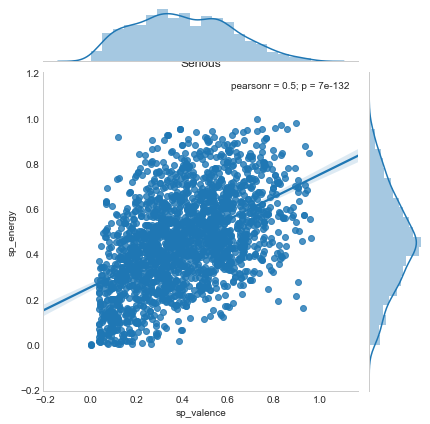

In [180]:
# create a dataframe with songs that are not classified as peaceful by GN
# df_notserious = df[df['gn_mood_1']!='Serious']

# create a dataframe with songs that are classified as peaceful by GN
df_serious = df[df['gn_mood_1']=='Serious']

# convert values to float
# df_notserious_sp = df_notserious
df_serious_sp    = df_serious
# df_notserious_sp = df_notserious_sp[['sp_valence', 'sp_energy']].astype('float64')
df_serious_sp    = df_serious_sp[['sp_valence', 'sp_energy']].astype('float64')

# # plot
# sns.jointplot(x='sp_valence', y='sp_energy', data=df_notserious_sp)
# ax = plt.gca()
# ax.set_title("Not Serious")

sns.jointplot(x='sp_valence', y='sp_energy', data=df_serious_sp, kind = 'reg')
ax = plt.gca()
print("Valence mean: ", df_serious_sp['sp_valence'].mean())
df_mean_values.loc['Serious','mean_valence'] = df_serious_sp['sp_valence'].mean()
df_mean_values.loc['Serious','mean_energy'] = df_serious_sp['sp_energy'].mean()
print("Energy mean: ", df_serious_sp['sp_energy'].mean())
ax.set_title("Serious")

## Digging into Sophisticated

Valence mean:  0.4025164179104477
Energy mean:  0.5040398009950245


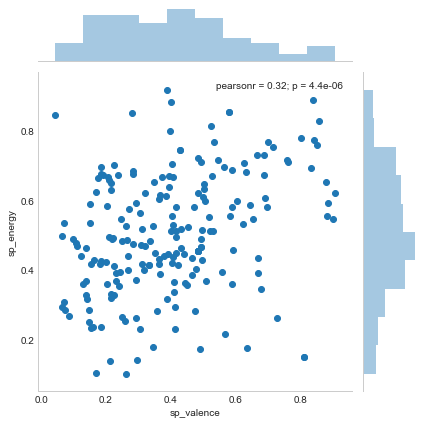

In [145]:
# create a dataframe with songs that are not classified as peaceful by GN
# df_notsophisticated = df[df['gn_mood_1']!='Sophisticated']

# create a dataframe with songs that are classified as peaceful by GN
df_sophisticated = df[df['gn_mood_1']=='Sophisticated']

# convert values to float
# df_notsophisticated_sp = df_notsophisticated
df_sophisticated_sp    = df_sophisticated
# df_notsophisticated_sp = df_notsophisticated_sp[['sp_valence', 'sp_energy']].astype('float64')
df_sophisticated_sp    = df_sophisticated_sp[['sp_valence', 'sp_energy']].astype('float64')

# # plot
# sns.jointplot(x='sp_valence', y='sp_energy', data=df_notsophisticated_sp)
# ax = plt.gca()
# ax.set_title("Not Sophisticated")

sns.jointplot(x='sp_valence', y='sp_energy', data=df_sophisticated_sp)
ax = plt.gca()
print("Valence mean: ", df_sophisticated_sp['sp_valence'].mean())
df_mean_values['Sophisticated'][0] = df_sophisticated_sp['sp_valence'].mean()
df_mean_values['Sophisticated'][0] = df_sophisticated_sp['sp_energy'].mean()
print("Energy mean: ", df_sophisticated_sp['sp_energy'].mean())
# ax.set_title("Sophisticated")

## Digging into Lively

Valence mean:  0.5737305882352942
Energy mean:  0.6084352941176471


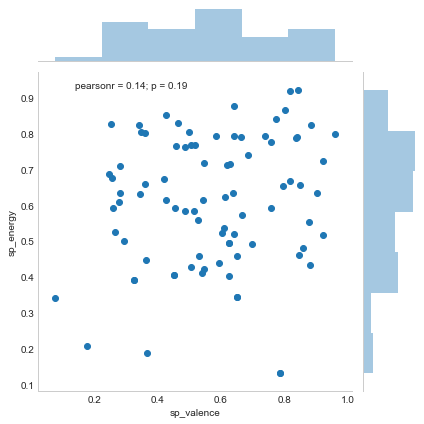

In [146]:
# create a dataframe with songs that are classified as peaceful by GN
df_lively = df[df['gn_mood_1']=='Lively']

# convert values to float
df_lively_sp           = df_lively
df_lively_sp           = df_lively_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_lively_sp)
ax = plt.gca()
print("Valence mean: ", df_lively_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Lively'] = df_lively_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Lively'] = df_lively_sp['sp_energy'].mean()
print("Energy mean: ", df_lively_sp['sp_energy'].mean())
# ax.set_title("Lively")

## Digging into Romantic

Valence mean:  0.3510700000000003
Energy mean:  0.4182274761904761


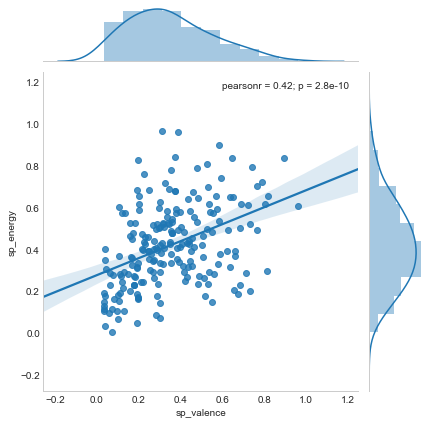

In [147]:
# create a dataframe with songs that are classified as peaceful by GN
df_romantic = df[df['gn_mood_1']=='Romantic']

# convert values to float
df_romantic_sp           = df_romantic
df_romantic_sp           = df_romantic_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_romantic_sp, kind = 'reg')
ax = plt.gca()
print("Valence mean: ", df_romantic_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Romantic'] = df_romantic_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Romantic'] = df_romantic_sp['sp_energy'].mean()
print("Energy mean: ", df_romantic_sp['sp_energy'].mean())
# ax.set_title("Romantic")

## Digging into Rowdy

Valence mean:  0.40507195357833653
Energy mean:  0.4550123017408125


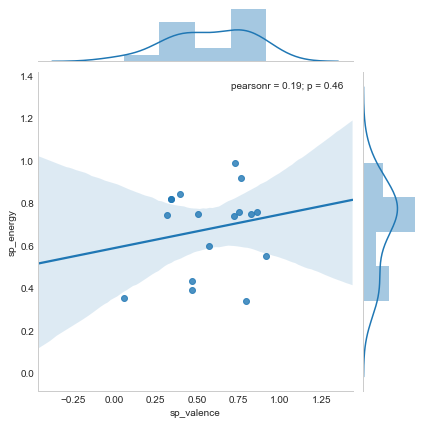

In [148]:
# create a dataframe with songs that are classified as peaceful by GN
df_rowdy = df[df['gn_mood_1']=='Rowdy']

# convert values to float
df_rowdy_sp           = df_rowdy
df_rowdy_sp           = df_rowdy_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_rowdy_sp, kind = 'reg')
ax = plt.gca()
print("Valence mean: ", df_serious_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Rowdy'] = df_rowdy_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Rowdy'] = df_rowdy_sp['sp_energy'].mean()
print("Energy mean: ", df_serious_sp['sp_energy'].mean())
# ax.set_title("Rowdy")

## Digging into Sensual

Valence mean:  0.3985515503875968
Energy mean:  0.5266240310077522


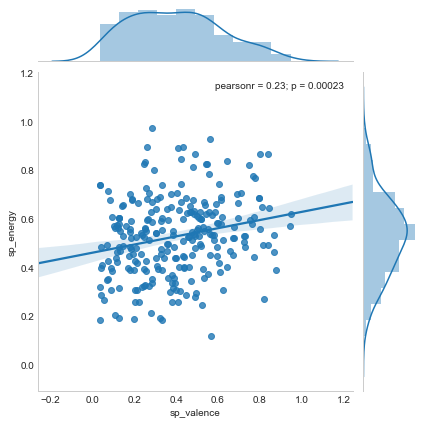

In [149]:
# create a dataframe with songs that are classified as peaceful by GN
df_sensual = df[df['gn_mood_1']=='Sensual']

# convert values to float
df_sensual_sp            = df_sensual
df_sensual_sp           = df_sensual_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_sensual_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_sensual_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Sensual'] = df_sensual_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Sensual'] = df_sensual_sp['sp_energy'].mean()
print("Energy mean: ", df_sensual_sp['sp_energy'].mean())
# ax.set_title("Sensual")

## Digging into Fiery

Valence mean:  0.5037879533678761
Energy mean:  0.6268724093264247


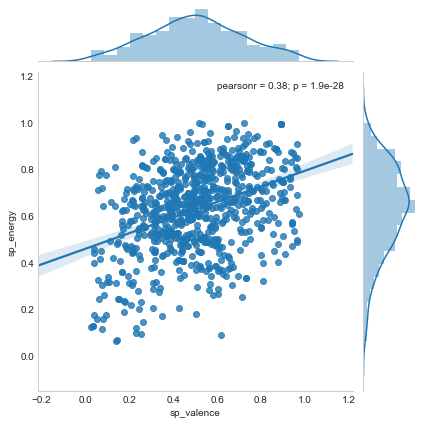

In [181]:
# create a dataframe with songs that are classified as peaceful by GN
df_fiery = df[df['gn_mood_1']=='Fiery']

# convert values to float
df_fiery_sp           = df_fiery
df_fiery_sp           = df_fiery_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_fiery_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_fiery_sp['sp_valence'].mean())
df_mean_values.loc['Fiery','mean_valence'] = df_fiery_sp['sp_valence'].mean()
df_mean_values.loc['Fiery','mean_energy'] = df_fiery_sp['sp_energy'].mean()
print("Energy mean: ", df_fiery_sp['sp_energy'].mean())
# ax.set_title("Fiery")

## Digging into Somber

Valence mean:  0.2098106750392465
Energy mean:  0.31545879120879106


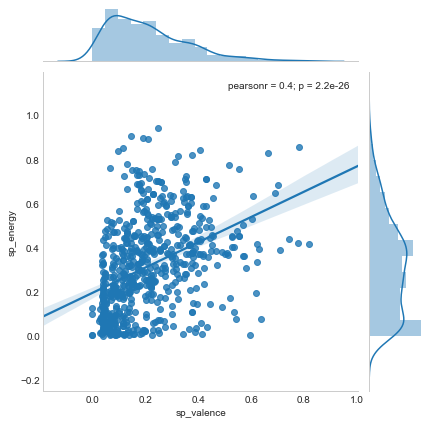

In [182]:
# create a dataframe with songs that are classified as peaceful by GN
df_somber = df[df['gn_mood_1']=='Somber']

# convert values to float
df_somber_sp            = df_somber
df_somber_sp           = df_somber_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_somber_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_somber_sp['sp_valence'].mean())
df_mean_values.loc['Somber','mean_valence'] = df_somber_sp['sp_valence'].mean()
df_mean_values.loc['Somber','mean_energy'] = df_somber_sp['sp_energy'].mean()
print("Energy mean: ", df_somber_sp['sp_energy'].mean())
# ax.set_title("Somber")

## Digging into Gritty

Valence mean:  0.4892052419354841
Energy mean:  0.4595560483870968


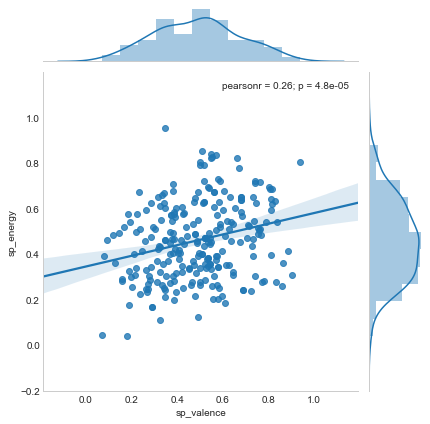

In [152]:
# create a dataframe with songs that are classified as peaceful by GN
df_gritty = df[df['gn_mood_1']=='Gritty']

# convert values to float
df_gritty_sp            = df_gritty
df_gritty_sp            = df_gritty_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_gritty_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_gritty_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Sensual'] = df_gritty_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Sensual'] = df_gritty_sp['sp_energy'].mean()
print("Energy mean: ", df_gritty_sp['sp_energy'].mean())
# ax.set_title("Gritty")

## Digging into Easygoing

Valence mean:  0.5157133620689653
Energy mean:  0.43400000000000005


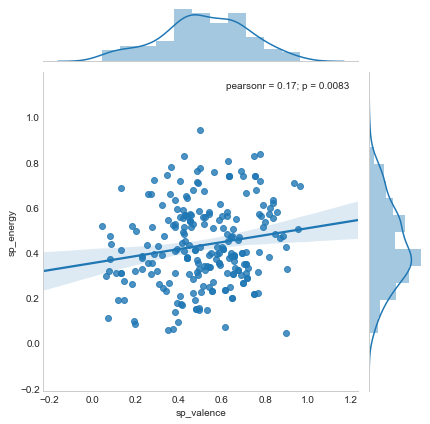

In [153]:
# create a dataframe with songs that are classified as peaceful by GN
df_easygoing = df[df['gn_mood_1']=='Easygoing']

# convert values to float
df_easygoing_sp            = df_easygoing
df_easygoing_sp            = df_easygoing_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_easygoing_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_easygoing_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Sensual'] = df_easygoing_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Sensual'] = df_easygoing_sp['sp_energy'].mean()
print("Energy mean: ", df_easygoing_sp['sp_energy'].mean())
# ax.set_title("Easygoing")

In [187]:
# sns.jointplot(x='mean_valence', y='mean_energy', data = df_mean_values)
print(df_mean_values['mean_valence'])

                 mood_1  mean_valence  mean_energy
0              Peaceful      0.000000     0.000000
1         Sophisticated      0.000000     0.000000
2               Serious      0.000000     0.000000
3                Somber      0.000000     0.000000
4                 Fiery      0.000000     0.000000
5             Easygoing      0.000000     0.000000
6              Stirring      0.000000     0.000000
7            Melancholy      0.000000     0.000000
8               Sensual      0.000000     0.000000
9                Lively      0.000000     0.000000
10             Brooding      0.000000     0.000000
11               Gritty      0.000000     0.000000
12             Romantic      0.000000     0.000000
13               Urgent      0.000000     0.000000
14          Sentimental      0.000000     0.000000
15              Defiant      0.000000     0.000000
16           Empowering      0.000000     0.000000
17               Upbeat      0.000000     0.000000
18           Energizing      0.

## Clustering on gracenote data

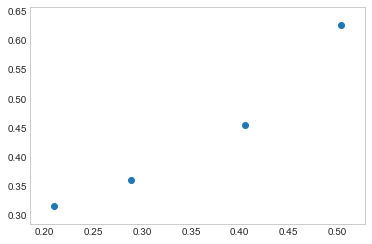

In [205]:
data_x = [0.28846, 0.405072, 0.503788, 0.20981]
data_y = [0.360690, 0.455012, 0.626872, 0.315459]
plt.scatter(data_x, data_y)
plt.xlabel
plt.legend()

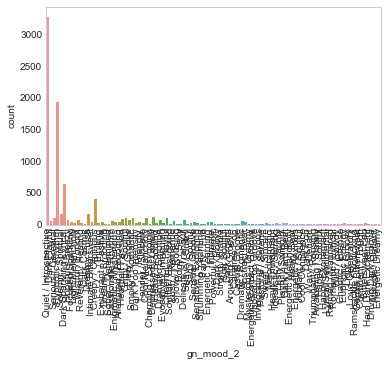

In [160]:
# Some moods are under-represented in the data compared to others
sns.countplot(df.gn_mood_2, orient = 'h')
plt.xticks(rotation=90);

In [140]:
con = get_db_handle()
#     print(con)
querystr = "select * from featuredb where gn_mood_1 like \'%Rowdy%\'"
#where name like \'%Shri%\'"
df_rowdy = query_db_translate_to_pandas(con, querystr)
print("Number of songs classified as rowdy are: \n", df_rowdy.count(axis=0)[0])

Number of songs classified as rowdy are: 
 17


In [141]:
con = get_db_handle()
querystr = "select * from featuredb where name like \'%Vrindavani%\' or name like \'%Brindabani%\' or name like \'%Sarang%\'"
#where name like \'%Shri%\'"
df_vrindavanisarang = query_db_translate_to_pandas(con, querystr)
print("Vrindavani Sarang: \n", df_vrindavanisarang.count(axis=0)[0])
print(df_vrindavanisarang.name.to_string())
print(df_vrindavanisarang.gn_mood_1)

Vrindavani Sarang: 
 117
0                                         Shuddha Sarang
1                                 Raga Brindabani Sarang
2                     Chaliye - Vrindavana Saranga - Adi
3                     Chaliye - Vrindavana Saranga - Adi
4        Rangapura Vihara - Vrindavana Saranga - Rupakam
5                     Raga Shudh Sarang: Alap in Teental
6                                      Brindabani Sarang
7                                  A Saranga Convergence
8      Jhaptal In 10 Beats / Raga Jhinjoti On Sarangi...
9      Taal Posta In 5 Beats / Raga Jhinjoti On Saran...
10     Raga Madhmad Sarang (Tarana in drut teental - ...
11     Taal Pancham Sawari In 15 Beats / Raga Asha Ma...
12       Relaxing Into Awareness - Rag Brindavani Sarang
13                Raga Brindavani Sarang - Alap - Ektaal
14                                     Brindabani sarang
15     Raga Shuddh Sarang - Drut Gat - Teentaal - Ins...
16                   Raga Shuddha Sarang: Alap In Ektaal
17    

In [142]:
print(df.shape)

(9021, 23)


In [143]:
numerical = ['sp_energy', 'sp_instrumentalness', 'sp_valence']
numerical_1 = ['sp_energy', 'sp_instrumentalness', 'sp_valence', 'sp_danceability', 'sp_loudness', 'sp_liveness',  'sp_tempo', 'sp_speechiness', 'sp_acousticness', 'sp_mode']
categorical = ['gn_genre_1', 'gn_genre_2', 'gn_genre_3', 'gn_mood_1', 'gn_mood_2', 'gn_tempo_1', 'gn_tempo_2', 'gn_tempo_3']

In [144]:
# print(df['sp_energy'], type(df['sp_energy']))

In [145]:
df1 = df[numerical_1]
print(df1.columns)
df2 = df1.astype('float64')
print(type(df2['sp_energy'][2]))

Index(['sp_energy', 'sp_instrumentalness', 'sp_valence', 'sp_danceability',
       'sp_loudness', 'sp_liveness', 'sp_tempo', 'sp_speechiness',
       'sp_acousticness', 'sp_mode'],
      dtype='object')
<class 'numpy.float64'>


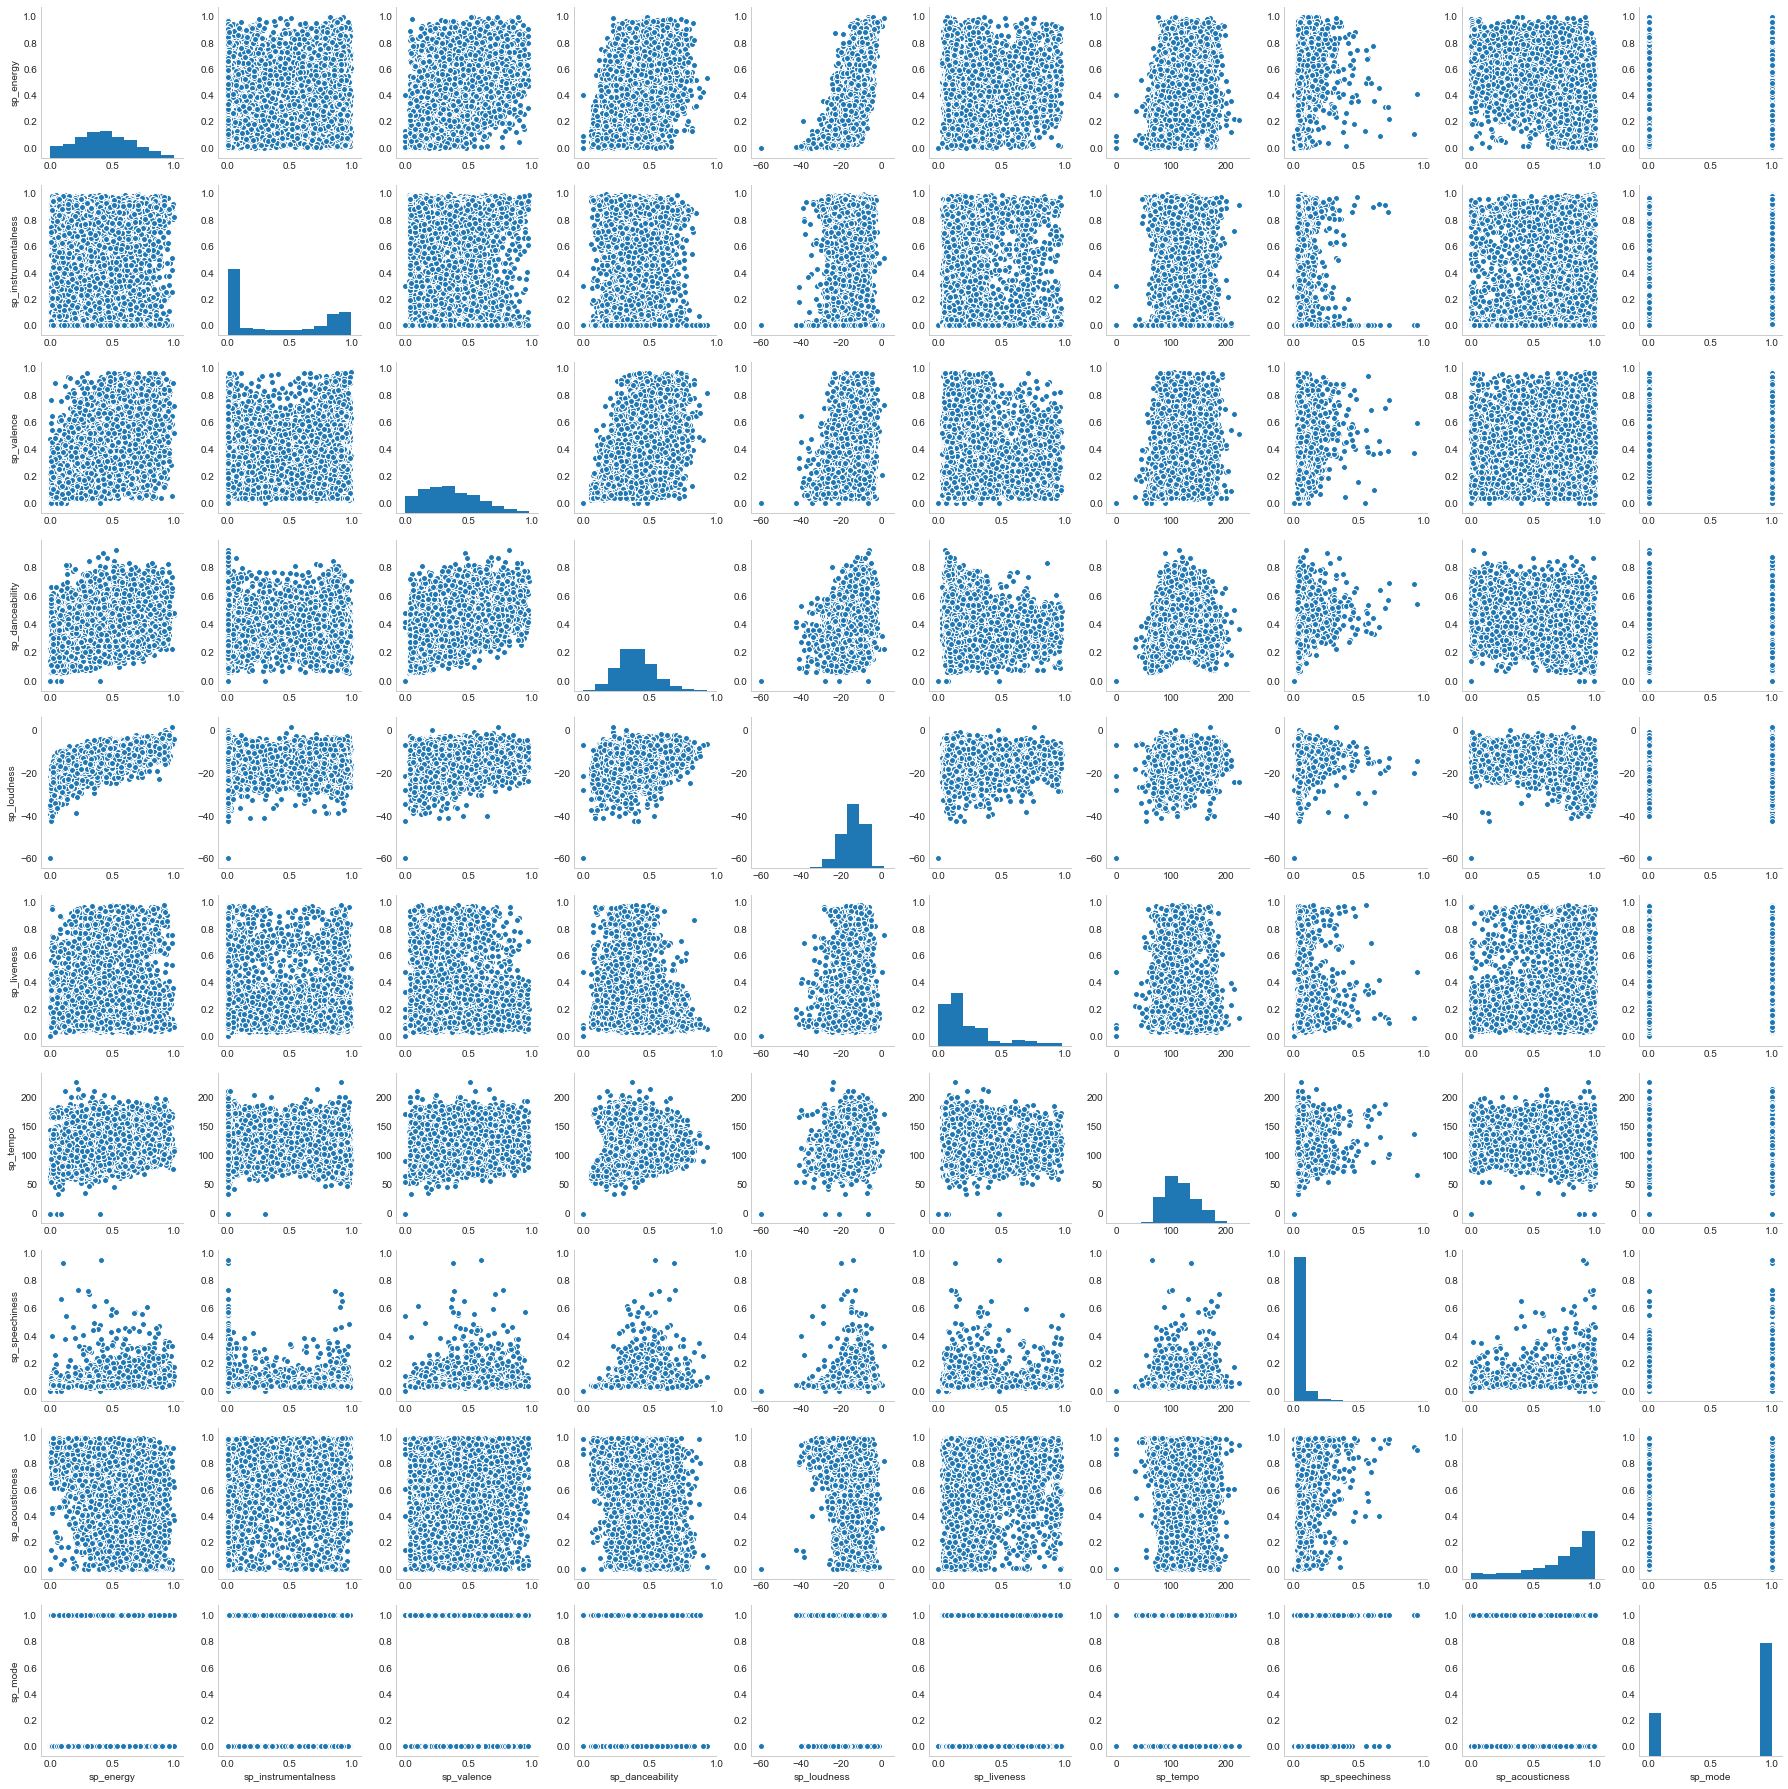

In [146]:
sns.pairplot(df2[numerical_1]) # plot univariate distribution

In [147]:
moods = list(df.gn_mood_1.unique())
print(moods)

['Peaceful', 'Sophisticated', 'Serious', 'Somber', 'Fiery', 'Easygoing', 'Stirring', 'Melancholy', 'Sensual', 'Lively', 'Brooding', 'Gritty', 'Romantic', 'Urgent', 'Sentimental', 'Defiant', 'Empowering', 'Upbeat', 'Energizing', 'Yearning', 'Cool', 'Excited', 'Aggressive', 'Tender', 'Rowdy']


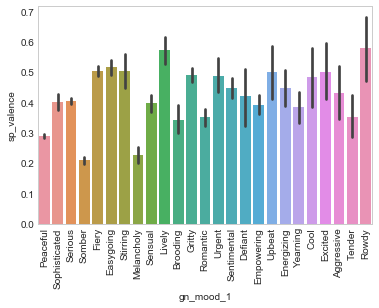

In [148]:
df[numerical_1] = df2[numerical_1]
sns.despine(left=True, bottom=True)
sns.barplot(x = 'gn_mood_1', y = 'sp_valence', data = df)
plt.xticks(rotation=90);


In [ ]:
## sns.barplot(x = 'gn_mood_1', y = 'sp_energy', data = df)
plt.xticks(rotation=90);
#min max scaling
#zscore

In [206]:
# create data
X = df.as_matrix(columns=["sp_valence", "sp_energy"])
x = X[:, 0]
y = X[:, 1]

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].set_xlabel('valence')
axes[0].set_ylabel('energy')
plt.legend()

# Everything sarts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].plot(x, y, 'ko')

# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[1].set_title('Hexbin')
axes[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)
axes[1].set_xlabel('valence')
axes[1].set_ylabel('energy')
plt.legend()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
# axes[2].set_title('Density')
plt.xlabel('valence')
plt.ylabel('energy')
plt.legend()
axis_label = ['0.0','0.2','0.4','0.6','0.8','1.0']
plt.xticks( 1/5*np.arange(6), axis_label)
plt.yticks( 1/5*np.arange(6), axis_label)
plt.tight_layout()
# plt.savefig('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/IndianClassicalMusic/Week2/data_plot.jpg', dpi = 300)
plt.show()



TypeError: unsupported operand type(s) for /: 'str' and 'int'

ValueError: Image size of 332298x325 pixels is too large. It must be less than 2^16 in each direction.

In [258]:
# Close communication with the database
close_db(con)